# FINAL COURSEWORK: NEURAL STYLE TRANSFER

Neural Style Transfer (NST) combines art and artificial intelligence, blending the essence of one image with another to create a new image. This project investigates NST, which uses deep learning to combine different visual elements in two images. The goal is to produce new images that preserve the original content and combine the style of a different image. I chose this project because I have been interested in the idea of combining art and technology for a long time. In the project, I used the photograph of my own dog, Foxy, and the work of Refik Anadol, one of the famous Turkish contemporary artists and aesthetics of machine intelligence pioneers.

## 1. Data Preparing

### 1.1 Importing Moduls and Proper Libraries

The project starts by importing essential Python libraries such as TensorFlow, Keras, Pandas, and Matplotlib. TensorFlow and Keras are crucial for their deep learning capabilities, especially in image processing and neural network modelling. Pandas is used for data handling and manipulation, while Matplotlib helps visualize the images and outcomes.

In [1]:
import pandas as pd
import sys
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import time
from tensorflow import keras
import numpy as np
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import save_img

### 1.2 Uploading the Images

In [2]:
from google.colab import files
uploaded=files.upload()

Saving foxy.jpeg to foxy (2).jpeg
Saving refik_anadol.jpeg to refik_anadol (2).jpeg


In [3]:
basedir = pathlib.Path("AI CW2 combination images")
if not basedir.is_dir():
    os.mkdir(basedir)

style_path = keras.utils.get_file("refik_anadol.jpeg", origin="file:/content/refik_anadol.jpeg")
content_path = keras.utils.get_file("foxy.jpeg", origin="file:/content/foxy.jpeg")

#### 1.2.1 Display the Images

In [4]:
original_width, original_height = tf.keras.utils.load_img(style_path).size


max_dim = 500
long_dim = max(original_width, original_height)
scale = max_dim / long_dim

img_height = round(original_height * scale)
img_width = round(original_width * scale)


Content Image My Lovely Dog Foxy


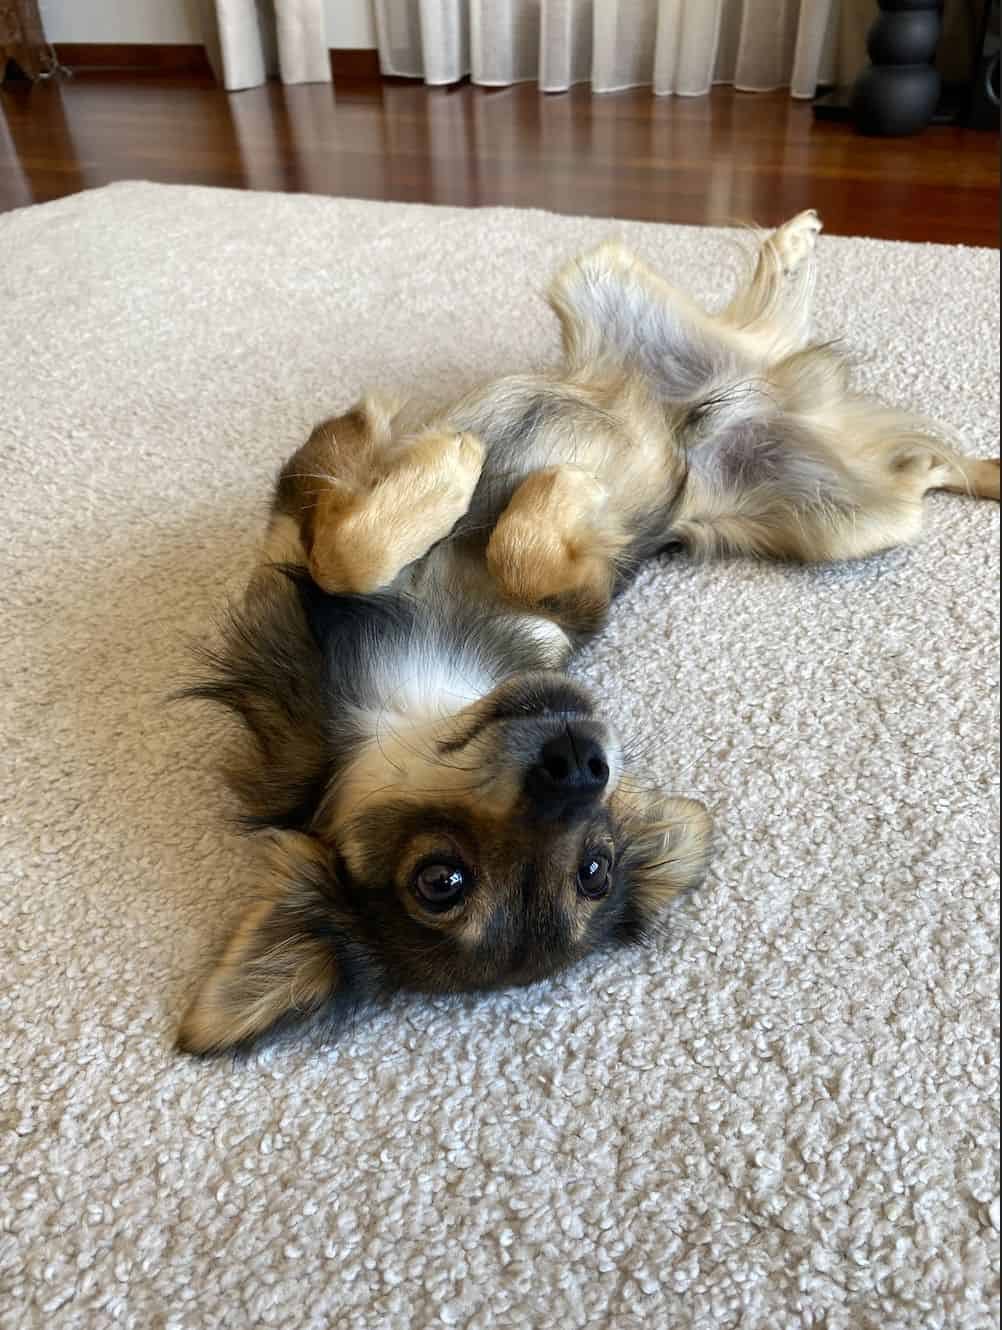

In [5]:
from IPython.display import Image, display

print("Content Image My Lovely Dog Foxy")
display(Image(content_path))

Style Image Refik Anadol's Work


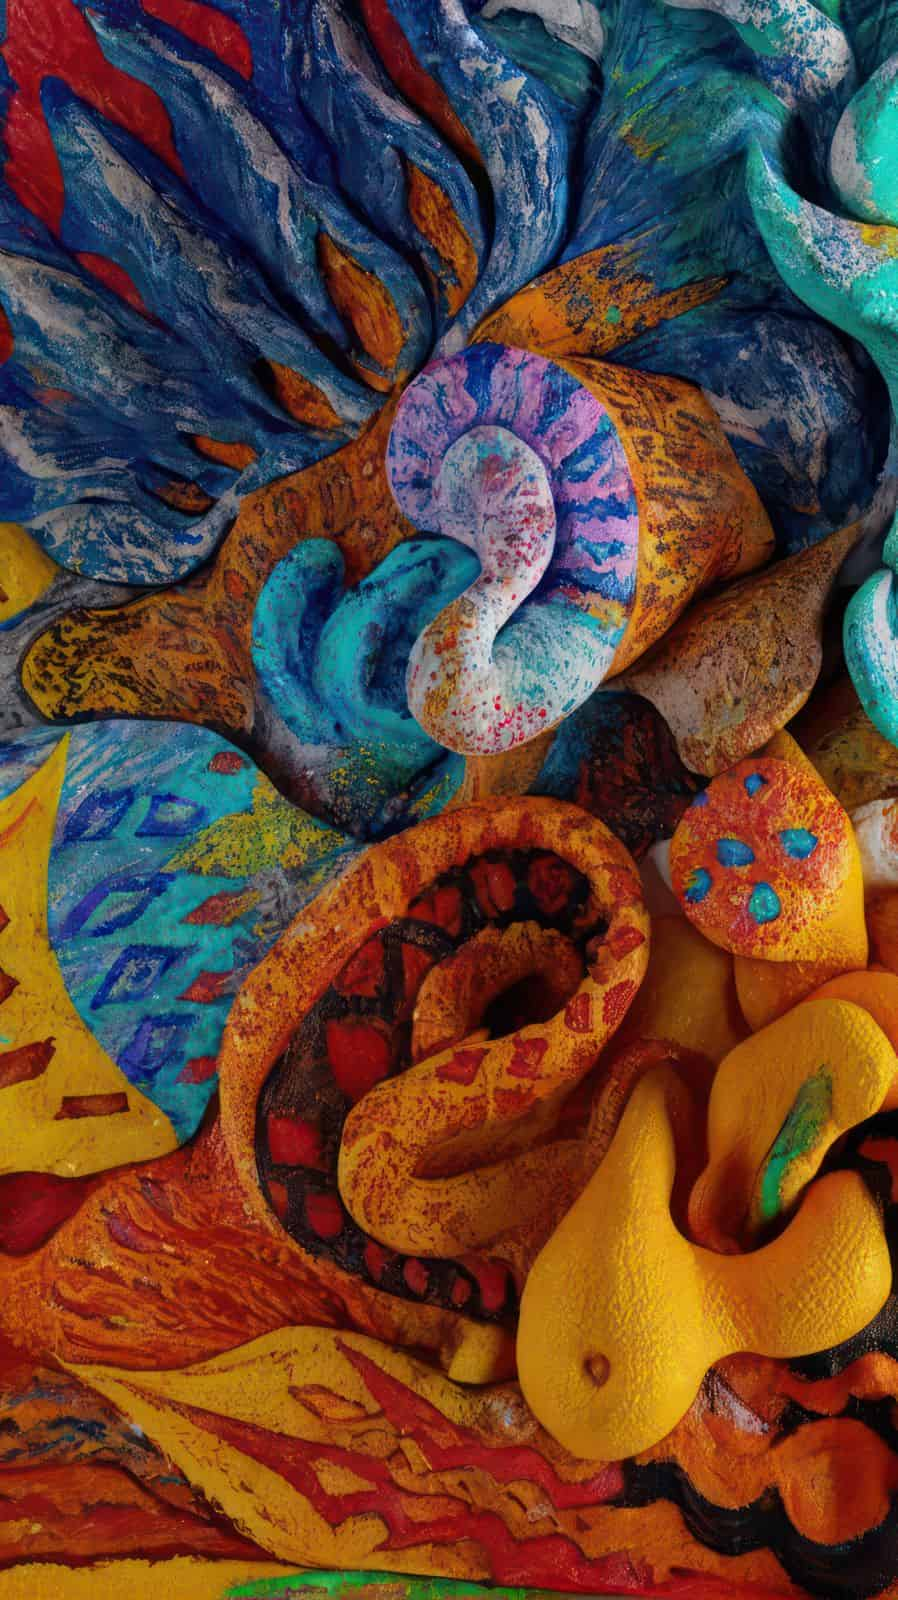

In [6]:
print("Style Image Refik Anadol's Work")
display(Image(style_path))


### 1.3 Helper Functions

The project develops functions for preprocessing (such as resizing and reformatting images) and deprocessing (converting processed images back to their original state). These functions adapt the images for the NST algorithm and subsequently render them in a viewable format.

In [7]:
def preprocess_image(image_path):
    img = tf.keras.utils.load_img(
        image_path, target_size=(img_height, img_width)
    )
    img = tf.keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img) # VGG19 preprocessing
    return img

def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]                         # BGR to RGB
    img = np.clip(img, 0, 255).astype("uint8")
    return img

## 2. Data Preprocessing

NST uses Gram matrices to extract image style. Loss metrics, including style, content, and total variation loss, optimize and guide the process to create the desired image output. NST blends image style and content.

### 2.1 Defining Gram Matrices and Losses

The function style_loss helps to compare the current generated image with the reference style image to ensure they have a similar style. To do this, it takes the Gram matrices of both images, subtracts, and normalizes them. This helps to calculate the difference in style. By summing up the L2 distances between the Gram matrices of the representations of the base image and the style reference image, extracted from different layers of VGG, it can capture colour and texture information at different scales.
On the other hand, the function content_loss helps to compare the current generated image with the original image to ensure they match. It takes the Gram matrices of the original and generated images and calculates the difference between them. By computing the L2 distance between the VGG features of the base image and the generated image's features, it ensures that the generated image stays close to the original image.
Finally, the function total_variation_loss ensures that the generated image is visually coherent. It achieves this by ensuring local spatial continuity between the pixels of the generated image.

In [8]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


def style_loss(style, target):
    T = gram_matrix(target)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(style - T)) / (4.0 * (channels ** 2) * (size ** 2))


def content_loss(content, target):
    return tf.reduce_sum(tf.square(target - content))


def total_variation_loss(x):
    # Horizontal
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :]

        - x[:, 1:, : img_width - 1, :]
    )
    # Vertical
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :]

         - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))



In [9]:
def gram_matrix_v(x, verbose=False):

    if verbose:
        print("x shape:         ", x.shape)
    x = tf.transpose(x, (2, 0, 1))
    if verbose:
        print("x reshaped:      ", x.shape)
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    if verbose:
        print("features shape:  ", features.shape)
        print("transposed shape:", tf.transpose(features).shape)
    gram = tf.matmul(features, tf.transpose(features))
    if verbose:
        print("gram shape:      ", gram.shape)
    return gram

gram_matrix_v(preprocess_image(content_path)[0], verbose=True)

x shape:          (500, 281, 3)
x reshaped:       (3, 500, 281)
features shape:   (3, 140500)
transposed shape: (140500, 3)
gram shape:       (3, 3)


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[7.9881696e+08, 7.4824710e+08, 6.9646822e+08],
       [7.4824710e+08, 7.1971347e+08, 6.8233741e+08],
       [6.9646822e+08, 6.8233741e+08, 6.6267622e+08]], dtype=float32)>

The gram_matrix_v function takes an input tensor x and calculates its Gram matrix, representing the correlations between features. If the verbose flag is set to True, it prints the shapes of intermediate tensors for debugging purposes. The input tensor is transposed to reorganize its dimensions, then flattened into a 2D tensor called features. The Gram matrix is computed by multiplying this feature tensor with its transpose, resulting in a square matrix representing feature correlations. This Gram matrix is a crucial component in tasks like neural style transfer, where it captures the style information of an image by quantifying how different features in the image relate to one another.

## 3. Defining the Model

The use of the VGG19 model is essential for the NST process. Its effectiveness in identifying images and extracting features makes it an ideal foundation for style transfer. The model allows for the manipulation of image features that are necessary for successful style transfer.

### 3.1 Pre-trained Model VGG19

In [10]:
model = vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [11]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 3.2 Creating a Baseline Model

This section aims to establish a basic baseline model for style transfer. It is essential to have a baseline model for comparison and evaluation of more complex methods.

#### 3.2.1 Creating Simple Blend Baseline as an Example

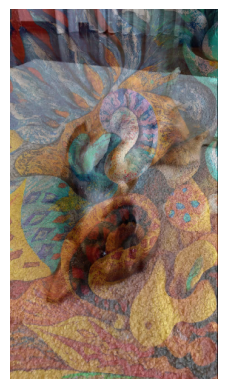

Image saved to AI CW2 combination images/blended_image.png


In [12]:

def simple_blend_baseline(content_path, style_path, blend_ratio=0.5):

    content_image = preprocess_image(content_path)
    style_image = preprocess_image(style_path)

# The images are the same size
    style_image = tf.image.resize(style_image, (content_image.shape[1], content_image.shape[2]))
# Simple blend
    blended_image = blend_ratio * content_image + (1 - blend_ratio) * style_image
    return deprocess_image(blended_image.numpy())

content_path = keras.utils.get_file("foxy.jpeg", origin="file:/content/foxy.jpeg")
style_path = keras.utils.get_file("refik_anadol.jpeg", origin="file:/content/refik_anadol.jpeg")
blended_image = simple_blend_baseline(content_path, style_path)

plt.imshow(blended_image)
plt.axis('off')
plt.show()

# Save the image
os.makedirs(basedir, exist_ok=True)
fname = basedir / "blended_image.png"
save_img(fname, blended_image)
print(f"Image saved to {fname}")

The provided code is used to define and execute a function called "simple_blend_baseline". This function blends two images, the content and style images, based on a specified ratio. The resulting image is then displayed and saved.

#### 3.2.2 The Baseline Model

A baseline model is constructed using simpler techniques, such as blending images at predetermined ratios. This model is a reference point for comparing the efficacy of more advanced NST approaches. As can be seen in the model summary, the "block4_conv2" layer is right in the middle of the model. In other words, content and style receive equal features from the image. Therefore, I will use "block1_conv1" and "block4_conv2" as the style layers of the base model.

In [13]:
# List of layers to use for the style loss.
style_layer_names = [ "block1_conv1",
                      "block4_conv2",
]
# The layer to use for the content loss.
content_layer_name = ["block5_conv2"]
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

num_content_layers = len(content_layer_name)
num_style_layers = len(style_layer_names)


base_image = preprocess_image(content_path)
style_reference_image = preprocess_image(style_path)

content_features = feature_extractor(base_image)

content_targets = {
    layer_name: content_features[layer_name]
    for layer_name, value
    in content_features.items()
    if layer_name in content_layer_name
}

style_features = feature_extractor(style_reference_image)

style_targets = {
    layer_name: gram_matrix(style_features[layer_name][0])
    for layer_name, value
    in style_features.items()
    if layer_name in style_layer_names
}

def compute_loss(combination_image):

    all_combination_features = feature_extractor(combination_image)

    c_loss = tf.zeros(shape=())
    for layer_name in content_layer_name:
        base_image_features = content_targets[layer_name][0]
        combination_features = all_combination_features[layer_name][0]
        c_loss += content_loss(base_image_features, combination_features)
    c_loss *= content_weight / num_content_layers

    s_loss = tf.zeros(shape=())
    for layer_name in style_layer_names:
        style_reference_features = style_targets[layer_name]
        combination_features = all_combination_features[layer_name][0]
        s_loss += style_loss(style_reference_features, combination_features)
    s_loss *= style_weight / num_style_layers


    v_loss = total_variation_weight * total_variation_loss(combination_image)
    loss = c_loss + s_loss + v_loss

    return loss, c_loss, s_loss, v_loss

In [14]:

def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss, c_loss, s_loss, v_loss = compute_loss(combination_image)
    grads = tape.gradient(loss, combination_image)
    optimizer.apply_gradients([(grads, combination_image)])
    return loss, c_loss, s_loss, v_loss

learning_rate = 100.

# Adam optimizer with .legacy because of the apple M2
optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=learning_rate,
    beta_1=0.99,
    epsilon=1e-1)

20 | loss: 13,500 content: 24 style: 9,959 variation: 3,517 | time: 0.0445
40 | loss: 8,637 content: 28 style: 5,204 variation: 3,405 | time: 0.0435
60 | loss: 7,410 content: 29 style: 3,762 variation: 3,619 | time: 0.0593
80 | loss: 6,555 content: 29 style: 2,845 variation: 3,681 | time: 0.0585
100 | loss: 5,768 content: 29 style: 2,224 variation: 3,516 | time: 0.0409
120 | loss: 5,057 content: 29 style: 1,833 variation: 3,196 | time: 0.0426
140 | loss: 4,373 content: 29 style: 1,544 variation: 2,801 | time: 0.0416
160 | loss: 3,788 content: 29 style: 1,347 variation: 2,411 | time: 0.0442
180 | loss: 3,290 content: 30 style: 1,187 variation: 2,074 | time: 0.0478
200 | loss: 2,897 content: 30 style: 1,069 variation: 1,798 | time: 0.0560
220 | loss: 2,583 content: 30 style: 964 variation: 1,590 | time: 0.0444
240 | loss: 2,337 content: 29 style: 882 variation: 1,426 | time: 0.0424
260 | loss: 2,132 content: 30 style: 812 variation: 1,290 | time: 0.0425
280 | loss: 1,955 content: 30 styl

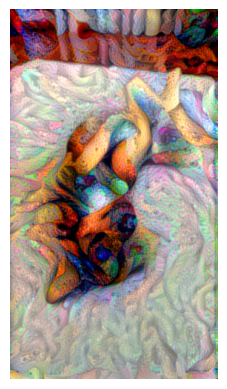

Average Total Loss: 4724.735123291016
Average Content Loss: 28.597639533281328
Average Style Loss: 2594.5208880615232
Average Variation Loss: 2101.61658493042


In [15]:
combination_image = tf.Variable(preprocess_image(content_path))

iterations = 400
display_every = 400
print_every = 20
save_intermediate = False

tot_loss = 0
tot_content_loss = 0
tot_style_loss = 0
tot_variation_loss = 0

for i in range(1, iterations + 1):
    start = time.time()
    loss, c_loss, s_loss, var_loss = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    end = time.time()

    tot_loss += loss.numpy().item()
    tot_content_loss += c_loss.numpy().item()
    tot_style_loss += s_loss.numpy().item()
    tot_variation_loss += var_loss.numpy().item()

    if i % print_every == 0:
        l = loss.numpy().item()
        c_l = c_loss.numpy().item()
        s_l = s_loss.numpy().item()
        v_l = var_loss.numpy().item()
        print(f"{i} | loss: {l:,.0f} content: {c_l:,.0f} style: {s_l:,.0f} variation: {v_l:,.0f} | time: {end-start:.4f}")

    if i % display_every == 0:
        img = deprocess_image(combination_image.numpy())
        if save_intermediate:
            fname = basedir / f"the_baseline_model_image_at_iteration_{i}.png"
            tf.keras.utils.save_img(fname, img)
        plt.axis('off')
        plt.imshow(img)
        plt.show()
avg_total_loss_base = tot_loss / iterations
avg_content_loss_base = tot_content_loss / iterations
avg_style_loss_base = tot_style_loss / iterations
avg_variation_loss_base = tot_variation_loss / iterations

# Print the average losses
print(f"Average Total Loss: {avg_total_loss_base}")
print(f"Average Content Loss: {avg_content_loss_base}")
print(f"Average Style Loss: {avg_style_loss_base}")
print(f"Average Variation Loss: {avg_variation_loss_base}")

img = deprocess_image(combination_image.numpy())
fname = basedir / f"the_baseline_model_at_iteration_{iterations}.png"
tf.keras.utils.save_img(fname, img)



In [16]:
loss_data = {
    'Model' : ['Base'],
    'Avr. Total Loss' : [avg_total_loss_base],
    'Avr. Content Loss' : [avg_content_loss_base],
    'Avr. Style Loss' : [avg_style_loss_base],
    'Avr. Variation Loss' : [avg_variation_loss_base]
}

loss_df= pd.DataFrame(loss_data)
loss_df

,Model,Avr. Total Loss,Avr. Content Loss,Avr. Style Loss,Avr. Variation Loss
0,Base,4724.735123,28.59764,2594.520888,2101.616585


Using these metrics, I can evaluate the effectiveness of any changes or optimizations I make to the algorithm in future runs.

### 3.3 Beat The Baseline

#### 3.3.1 Model1- 5 Style Layers

20 | loss: 7,606 content: 20 style: 4,587 variation: 2,999 | time: 0.0425
40 | loss: 5,657 content: 25 style: 3,197 variation: 2,435 | time: 0.0570
60 | loss: 4,190 content: 27 style: 2,041 variation: 2,121 | time: 0.0429
80 | loss: 3,614 content: 28 style: 1,513 variation: 2,073 | time: 0.0434
100 | loss: 3,335 content: 28 style: 1,237 variation: 2,070 | time: 0.0559
120 | loss: 3,024 content: 27 style: 1,007 variation: 1,990 | time: 0.0454
140 | loss: 2,707 content: 27 style: 860 variation: 1,819 | time: 0.0439
160 | loss: 2,386 content: 27 style: 739 variation: 1,620 | time: 0.0635
180 | loss: 2,104 content: 28 style: 660 variation: 1,417 | time: 0.0677
200 | loss: 1,865 content: 28 style: 600 variation: 1,238 | time: 0.0440
220 | loss: 1,674 content: 28 style: 554 variation: 1,093 | time: 0.0409
240 | loss: 1,524 content: 28 style: 512 variation: 984 | time: 0.0430
260 | loss: 1,400 content: 28 style: 475 variation: 897 | time: 0.0426
280 | loss: 1,295 content: 28 style: 447 variat

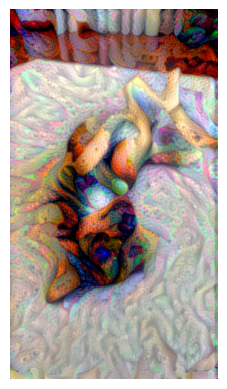

Average Total Loss: 2892.532364807129
Average Content Loss: 26.83734460256994
Average Style Loss: 1428.0595501708985
Average Variation Loss: 1437.6354641723633


In [17]:
style_layer_names1 = ['block1_conv1',
                     'block2_conv1',
                     'block3_conv1',
                     'block4_conv1',
                     'block5_conv1',
                    ]

content_layer_name1 = ["block5_conv2"]
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

num_content_layers = len(content_layer_name1)
num_style_layers = len(style_layer_names1)


model1 = vgg19.VGG19(weights="imagenet", include_top=False)


outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])


feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

base_image = preprocess_image(content_path)
style_reference_image = preprocess_image(style_path)

content_features = feature_extractor(base_image)

content_targets = {
    layer_name: content_features[layer_name]
    for layer_name, value
    in content_features.items()
    if layer_name in content_layer_name
}

style_features = feature_extractor(style_reference_image)

style_targets = {
    layer_name: gram_matrix(style_features[layer_name][0])
    for layer_name, value
    in style_features.items()
    if layer_name in style_layer_names
}

def style_loss(style, target):
    T = gram_matrix(target)
    channels = 3
    size = img_height * img_width

    return tf.reduce_sum(tf.square(style - T)) / (4.0 * (channels ** 2) * (size ** 2))

def content_loss(content, target):
    return tf.reduce_sum(tf.square(target - content))


def total_variation_loss(x):

    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :]

        - x[:, 1:, : img_width - 1, :]
    )

    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :]

         - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss, c_loss, s_loss, v_loss = compute_loss(combination_image)
    grads = tape.gradient(loss, combination_image)
    optimizer.apply_gradients([(grads, combination_image)])
    return loss, c_loss, s_loss, v_loss

    learning_rate = 100.


optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=learning_rate,
    beta_1=0.99,
    epsilon=1e-1)

combination_image = tf.Variable(preprocess_image(content_path))

iterations = 400
display_every = 400
print_every = 20
save_intermediate = False

tot_loss = 0
tot_content_loss = 0
tot_style_loss = 0
tot_variation_loss = 0

for i in range(1, iterations + 1):
    start = time.time()
    loss, c_loss, s_loss, var_loss = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    end = time.time()

    tot_loss += loss.numpy().item()
    tot_content_loss += c_loss.numpy().item()
    tot_style_loss += s_loss.numpy().item()
    tot_variation_loss += var_loss.numpy().item()

    if i % print_every == 0:
        l = loss.numpy().item()
        c_l = c_loss.numpy().item()
        s_l = s_loss.numpy().item()
        v_l = var_loss.numpy().item()
        print(f"{i} | loss: {l:,.0f} content: {c_l:,.0f} style: {s_l:,.0f} variation: {v_l:,.0f} | time: {end-start:.4f}")

    if i % display_every == 0:
        img = deprocess_image(combination_image.numpy())
        if save_intermediate:
            fname = basedir / f"Model1_image_at_iteration_{i}.png"
            tf.keras.utils.save_img(fname, img)
        plt.axis('off')
        plt.imshow(img)
        plt.show()
avg_total_loss1 = tot_loss / iterations
avg_content_loss1 = tot_content_loss / iterations
avg_style_loss1 = tot_style_loss / iterations
avg_variation_loss1 = tot_variation_loss / iterations

# Print the average losses
print(f"Average Total Loss: {avg_total_loss1}")
print(f"Average Content Loss: {avg_content_loss1}")
print(f"Average Style Loss: {avg_style_loss1}")
print(f"Average Variation Loss: {avg_variation_loss1}")

img = deprocess_image(combination_image.numpy())
fname = basedir / f"Model1_image_at_iteration_{iterations}.png"
tf.keras.utils.save_img(fname, img)




In [18]:
loss_data = {
    'Model' : ['Base', 'Model1'],
    'Avr. Total Loss' : [avg_total_loss_base, avg_total_loss1],
    'Avr. Content Loss' : [avg_content_loss_base, avg_content_loss1],
    'Avr. Style Loss' : [avg_style_loss_base, avg_style_loss1],
    'Avr. Variation Loss' : [avg_variation_loss_base, avg_variation_loss1]
}

loss_df= pd.DataFrame(loss_data)
loss_df

,Model,Avr. Total Loss,Avr. Content Loss,Avr. Style Loss,Avr. Variation Loss
0,Base,4724.735123,28.597640,2594.520888,2101.616585
1,Model1,2892.532365,26.837345,1428.059550,1437.635464


Style features are more noticeable in the Image compared to the baseline model. However, visually, there needs to be a clear distinction. Avr. Total Loss, Avr. Style Loss and Avr. Variation Loss has decreased significantly. Avr. There was also a slight increase in Content Loss.

#### 3.3.2 Model2- Add 3 Content Layers to Model1

This model increases the number of content layers compared to Model1. Let's follow these steps to see more content features in the image and reduce content loss:


20 | loss: 7,592 content: 5 style: 4,587 variation: 3,000 | time: 0.0647
40 | loss: 5,643 content: 6 style: 3,200 variation: 2,436 | time: 0.0439
60 | loss: 4,172 content: 7 style: 2,043 variation: 2,123 | time: 0.0413
80 | loss: 3,595 content: 7 style: 1,513 variation: 2,075 | time: 0.0426
100 | loss: 3,316 content: 7 style: 1,238 variation: 2,072 | time: 0.0429
120 | loss: 3,005 content: 7 style: 1,007 variation: 1,991 | time: 0.0469
140 | loss: 2,688 content: 7 style: 860 variation: 1,821 | time: 0.0577
160 | loss: 2,367 content: 7 style: 737 variation: 1,622 | time: 0.0578
180 | loss: 2,085 content: 7 style: 660 variation: 1,418 | time: 0.0407
200 | loss: 1,845 content: 7 style: 600 variation: 1,238 | time: 0.0416
220 | loss: 1,654 content: 7 style: 554 variation: 1,093 | time: 0.0445
240 | loss: 1,503 content: 7 style: 511 variation: 984 | time: 0.0417
260 | loss: 1,378 content: 7 style: 473 variation: 898 | time: 0.0422
280 | loss: 1,274 content: 7 style: 445 variation: 821 | tim

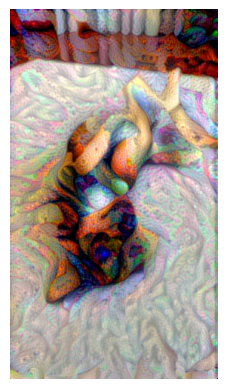

Average Total Loss: 2873.2158833312988
Average Content Loss: 6.990846181679517
Average Style Loss: 1427.6107083892823
Average Variation Loss: 1438.6143237304686


In [19]:
style_layer_names2 = ['block1_conv1',
                     'block2_conv1',
                     'block3_conv1',
                     'block4_conv1',
                     'block5_conv1',
                    ]

content_layer_name2 = [
    'block2_conv2',  # Lower level content features
    'block3_conv3',  # Middle level content features
    'block4_conv3',  # Higher level content features
    'block5_conv2',   # Highest content features available in VGG19
]

total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

num_content_layers = len(content_layer_name2)
num_style_layers = len(style_layer_names2)


model2 = vgg19.VGG19(weights="imagenet", include_top=False)


outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])


feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

base_image = preprocess_image(content_path)
style_reference_image = preprocess_image(style_path)

content_features = feature_extractor(base_image)

content_targets = {
    layer_name: content_features[layer_name]
    for layer_name, value
    in content_features.items()
    if layer_name in content_layer_name
}

style_features = feature_extractor(style_reference_image)

style_targets = {
    layer_name: gram_matrix(style_features[layer_name][0])
    for layer_name, value
    in style_features.items()
    if layer_name in style_layer_names
}

def style_loss(style, target):
    T = gram_matrix(target)
    channels = 3
    size = img_height * img_width

    return tf.reduce_sum(tf.square(style - T)) / (4.0 * (channels ** 2) * (size ** 2))

def content_loss(content, target):
    return tf.reduce_sum(tf.square(target - content))


def total_variation_loss(x):

    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :]

        - x[:, 1:, : img_width - 1, :]
    )

    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :]

         - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss, c_loss, s_loss, v_loss = compute_loss(combination_image)
    grads = tape.gradient(loss, combination_image)
    optimizer.apply_gradients([(grads, combination_image)])
    return loss, c_loss, s_loss, v_loss

    learning_rate = 100.


optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=learning_rate,
    beta_1=0.99,
    epsilon=1e-1)

combination_image = tf.Variable(preprocess_image(content_path))

iterations = 400
display_every = 400
print_every = 20
save_intermediate = False

tot_loss = 0
tot_content_loss = 0
tot_style_loss = 0
tot_variation_loss = 0

for i in range(1, iterations + 1):
    start = time.time()
    loss, c_loss, s_loss, var_loss = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    end = time.time()

    tot_loss += loss.numpy().item()
    tot_content_loss += c_loss.numpy().item()
    tot_style_loss += s_loss.numpy().item()
    tot_variation_loss += var_loss.numpy().item()

    if i % print_every == 0:
        l = loss.numpy().item()
        c_l = c_loss.numpy().item()
        s_l = s_loss.numpy().item()
        v_l = var_loss.numpy().item()
        print(f"{i} | loss: {l:,.0f} content: {c_l:,.0f} style: {s_l:,.0f} variation: {v_l:,.0f} | time: {end-start:.4f}")

    if i % display_every == 0:
        img = deprocess_image(combination_image.numpy())
        if save_intermediate:
            fname = basedir / f"Model2_image_at_iteration_{i}.png"
            tf.keras.utils.save_img(fname, img)
        plt.axis('off')
        plt.imshow(img)
        plt.show()
avg_total_loss2 = tot_loss / iterations
avg_content_loss2 = tot_content_loss / iterations
avg_style_loss2 = tot_style_loss / iterations
avg_variation_loss2 = tot_variation_loss / iterations


print(f"Average Total Loss: {avg_total_loss2}")
print(f"Average Content Loss: {avg_content_loss2}")
print(f"Average Style Loss: {avg_style_loss2}")
print(f"Average Variation Loss: {avg_variation_loss2}")

img = deprocess_image(combination_image.numpy())
fname = basedir / f"Model2_image_at_iteration_{iterations}.png"
tf.keras.utils.save_img(fname, img)




In [20]:
loss_data = {
    'Model' : ['Base', 'Model1', 'Model2'],
    'Avr. Total Loss' : [avg_total_loss_base, avg_total_loss1, avg_total_loss2],
    'Avr. Content Loss' : [avg_content_loss_base, avg_content_loss1, avg_content_loss2],
    'Avr. Style Loss' : [avg_style_loss_base, avg_style_loss1, avg_style_loss2],
    'Avr. Variation Loss' : [avg_variation_loss_base, avg_variation_loss1, avg_variation_loss2]
}

loss_df= pd.DataFrame(loss_data)
loss_df

,Model,Avr. Total Loss,Avr. Content Loss,Avr. Style Loss,Avr. Variation Loss
0,Base,4724.735123,28.597640,2594.520888,2101.616585
1,Model1,2892.532365,26.837345,1428.059550,1437.635464
2,Model2,2873.215883,6.990846,1427.610708,1438.614324


Although there is not much difference in the visual compared to Model1, there has been a visible decrease in Avr. Content Loss. Avr. Variation Loss has increased very slightly, but all losses other than that have decreased. Model2 can be interpreted as a better model than Model1.

#### 3.3.3 Model3- Adjust the Model2's Weights (Increasing Style and Content Weights)

Let's try increasing the style and content weights of Model2.

20 | loss: 31,041 content: 72 style: 25,004 variation: 5,965 | time: 0.0436
40 | loss: 25,018 content: 72 style: 16,395 variation: 8,551 | time: 0.0422
60 | loss: 20,794 content: 74 style: 11,457 variation: 9,264 | time: 0.0407
80 | loss: 17,229 content: 76 style: 8,470 variation: 8,683 | time: 0.0414
100 | loss: 14,298 content: 77 style: 6,623 variation: 7,598 | time: 0.0504
120 | loss: 11,828 content: 78 style: 5,297 variation: 6,454 | time: 0.0536
140 | loss: 9,876 content: 78 style: 4,360 variation: 5,438 | time: 0.0428
160 | loss: 8,348 content: 78 style: 3,644 variation: 4,626 | time: 0.0457
180 | loss: 7,174 content: 78 style: 3,106 variation: 3,989 | time: 0.0413
200 | loss: 6,244 content: 79 style: 2,689 variation: 3,476 | time: 0.0445
220 | loss: 5,503 content: 79 style: 2,377 variation: 3,047 | time: 0.0408
240 | loss: 4,876 content: 79 style: 2,113 variation: 2,684 | time: 0.0470
260 | loss: 4,342 content: 78 style: 1,894 variation: 2,369 | time: 0.0529
280 | loss: 3,895 co

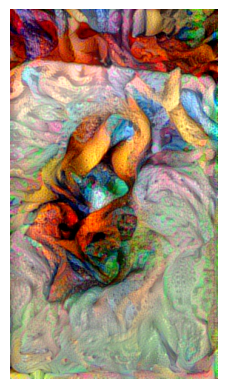

Average Total Loss: 11569.7251953125
Average Content Loss: 76.34944823265076
Average Style Loss: 7277.5089031982425
Average Variation Loss: 4215.866819152832


In [21]:
style_layer_names2 = ['block1_conv1',
                     'block2_conv1',
                     'block3_conv1',
                     'block4_conv1',
                     'block5_conv1',
                    ]

content_layer_name2 = [
    'block2_conv2',
    'block3_conv3',
    'block4_conv3',
    'block5_conv2',
]

total_variation_weight = 1e-6
style_weight = 1e-5
content_weight = 2.5e-7

num_content_layers = len(content_layer_name2)
num_style_layers = len(style_layer_names2)


model3 = vgg19.VGG19(weights="imagenet", include_top=False)


outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])


feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

base_image = preprocess_image(content_path)
style_reference_image = preprocess_image(style_path)

content_features = feature_extractor(base_image)

content_targets = {
    layer_name: content_features[layer_name]
    for layer_name, value
    in content_features.items()
    if layer_name in content_layer_name
}

style_features = feature_extractor(style_reference_image)

style_targets = {
    layer_name: gram_matrix(style_features[layer_name][0])
    for layer_name, value
    in style_features.items()
    if layer_name in style_layer_names
}

def style_loss(style, target):
    T = gram_matrix(target)
    channels = 3
    size = img_height * img_width

    return tf.reduce_sum(tf.square(style - T)) / (4.0 * (channels ** 2) * (size ** 2))

def content_loss(content, target):
    return tf.reduce_sum(tf.square(target - content))


def total_variation_loss(x):

    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :]

        - x[:, 1:, : img_width - 1, :]
    )

    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :]

         - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss, c_loss, s_loss, v_loss = compute_loss(combination_image)
    grads = tape.gradient(loss, combination_image)
    optimizer.apply_gradients([(grads, combination_image)])
    return loss, c_loss, s_loss, v_loss

    learning_rate = 100.


optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=learning_rate,
    beta_1=0.99,
    epsilon=1e-1)

combination_image = tf.Variable(preprocess_image(content_path))

iterations = 400
display_every = 400
print_every = 20
save_intermediate = False

tot_loss = 0
tot_content_loss = 0
tot_style_loss = 0
tot_variation_loss = 0

for i in range(1, iterations + 1):
    start = time.time()
    loss, c_loss, s_loss, var_loss = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    end = time.time()

    tot_loss += loss.numpy().item()
    tot_content_loss += c_loss.numpy().item()
    tot_style_loss += s_loss.numpy().item()
    tot_variation_loss += var_loss.numpy().item()

    if i % print_every == 0:
        l = loss.numpy().item()
        c_l = c_loss.numpy().item()
        s_l = s_loss.numpy().item()
        v_l = var_loss.numpy().item()
        print(f"{i} | loss: {l:,.0f} content: {c_l:,.0f} style: {s_l:,.0f} variation: {v_l:,.0f} | time: {end-start:.4f}")

    if i % display_every == 0:
        img = deprocess_image(combination_image.numpy())
        if save_intermediate:
            fname = basedir / f"Model3_image_at_iteration_{i}.png"
            tf.keras.utils.save_img(fname, img)
        plt.axis('off')
        plt.imshow(img)
        plt.show()
avg_total_loss3 = tot_loss / iterations
avg_content_loss3 = tot_content_loss / iterations
avg_style_loss3 = tot_style_loss / iterations
avg_variation_loss3 = tot_variation_loss / iterations


print(f"Average Total Loss: {avg_total_loss3}")
print(f"Average Content Loss: {avg_content_loss3}")
print(f"Average Style Loss: {avg_style_loss3}")
print(f"Average Variation Loss: {avg_variation_loss3}")

img = deprocess_image(combination_image.numpy())
fname = basedir / f"Model3_image_at_iteration_{iterations}.png"
tf.keras.utils.save_img(fname, img)




In [22]:
loss_data = {
    'Model' : ['Base', 'Model1', 'Model2', 'Model3'],
    'Avr. Total Loss' : [avg_total_loss_base, avg_total_loss1, avg_total_loss2, avg_total_loss3],
    'Avr. Content Loss' : [avg_content_loss_base, avg_content_loss1, avg_content_loss2, avg_content_loss3],
    'Avr. Style Loss' : [avg_style_loss_base, avg_style_loss1, avg_style_loss2, avg_style_loss3],
    'Avr. Variation Loss' : [avg_variation_loss_base, avg_variation_loss1, avg_variation_loss2, avg_variation_loss3]
}

loss_df= pd.DataFrame(loss_data)
loss_df

,Model,Avr. Total Loss,Avr. Content Loss,Avr. Style Loss,Avr. Variation Loss
0,Base,4724.735123,28.597640,2594.520888,2101.616585
1,Model1,2892.532365,26.837345,1428.059550,1437.635464
2,Model2,2873.215883,6.990846,1427.610708,1438.614324
3,Model3,11569.725195,76.349448,7277.508903,4215.866819


After these adjustments, the visuals greatly deteriorated, and there was a serious increase in the number of losses. It is clearly seen that this model is weaker than other models.

#### 3.3.4 Model4- Adjusting Variation Weight (Increasing)

20 | loss: 50,781 content: 73 style: 20,572 variation: 30,137 | time: 0.0421
40 | loss: 42,105 content: 72 style: 11,263 variation: 30,770 | time: 0.0419
60 | loss: 30,002 content: 75 style: 8,181 variation: 21,746 | time: 0.0442
80 | loss: 25,353 content: 76 style: 6,434 variation: 18,843 | time: 0.0457
100 | loss: 21,012 content: 78 style: 5,337 variation: 15,598 | time: 0.0569
120 | loss: 17,852 content: 78 style: 4,498 variation: 13,277 | time: 0.0643
140 | loss: 15,399 content: 79 style: 3,865 variation: 11,455 | time: 0.0448
160 | loss: 13,459 content: 80 style: 3,417 variation: 9,962 | time: 0.0426
180 | loss: 11,847 content: 80 style: 3,064 variation: 8,703 | time: 0.0410
200 | loss: 10,535 content: 81 style: 2,807 variation: 7,647 | time: 0.0412
220 | loss: 9,404 content: 81 style: 2,586 variation: 6,736 | time: 0.0419
240 | loss: 8,495 content: 82 style: 2,396 variation: 6,017 | time: 0.0671
260 | loss: 7,734 content: 82 style: 2,244 variation: 5,407 | time: 0.0427
280 | loss

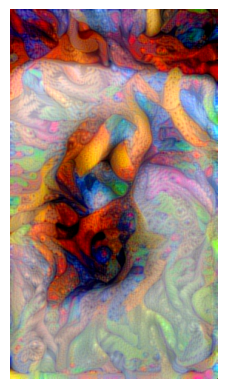

Average Total Loss: 17958.85721069336
Average Content Loss: 78.447814412117
Average Style Loss: 6526.140480651856
Average Variation Loss: 11354.268924560547


In [23]:
style_layer_names2 = ['block1_conv1',
                     'block2_conv1',
                     'block3_conv1',
                     'block4_conv1',
                     'block5_conv1',]

content_layer_name2 = [
    'block2_conv2',
    'block3_conv3',
    'block4_conv3',
    'block5_conv2',
]

total_variation_weight = 1e-5
style_weight = 1e-5
content_weight = 2.5e-7

num_content_layers = len(content_layer_name2)
num_style_layers = len(style_layer_names2)


model4 = vgg19.VGG19(weights="imagenet", include_top=False)


outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])


feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

base_image = preprocess_image(content_path)
style_reference_image = preprocess_image(style_path)

content_features = feature_extractor(base_image)

content_targets = {
    layer_name: content_features[layer_name]
    for layer_name, value
    in content_features.items()
    if layer_name in content_layer_name
}

style_features = feature_extractor(style_reference_image)

style_targets = {
    layer_name: gram_matrix(style_features[layer_name][0])
    for layer_name, value
    in style_features.items()
    if layer_name in style_layer_names
}

def style_loss(style, target):
    T = gram_matrix(target)
    channels = 3
    size = img_height * img_width

    return tf.reduce_sum(tf.square(style - T)) / (4.0 * (channels ** 2) * (size ** 2))

def content_loss(content, target):
    return tf.reduce_sum(tf.square(target - content))


def total_variation_loss(x):

    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :]

        - x[:, 1:, : img_width - 1, :]
    )
    l
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :]

         - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss, c_loss, s_loss, v_loss = compute_loss(combination_image)
    grads = tape.gradient(loss, combination_image)
    optimizer.apply_gradients([(grads, combination_image)])
    return loss, c_loss, s_loss, v_loss

    learning_rate = 100.


optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=learning_rate,
    beta_1=0.99,
    epsilon=1e-1)

combination_image = tf.Variable(preprocess_image(content_path))

iterations = 400
display_every = 400
print_every = 20
save_intermediate = False

tot_loss = 0
tot_content_loss = 0
tot_style_loss = 0
tot_variation_loss = 0

for i in range(1, iterations + 1):
    start = time.time()
    loss, c_loss, s_loss, var_loss = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    end = time.time()

    tot_loss += loss.numpy().item()
    tot_content_loss += c_loss.numpy().item()
    tot_style_loss += s_loss.numpy().item()
    tot_variation_loss += var_loss.numpy().item()

    if i % print_every == 0:
        l = loss.numpy().item()
        c_l = c_loss.numpy().item()
        s_l = s_loss.numpy().item()
        v_l = var_loss.numpy().item()
        print(f"{i} | loss: {l:,.0f} content: {c_l:,.0f} style: {s_l:,.0f} variation: {v_l:,.0f} | time: {end-start:.4f}")

    if i % display_every == 0:
        img = deprocess_image(combination_image.numpy())
        if save_intermediate:
            fname = basedir / f"Model4_image_at_iteration_{i}.png"
            tf.keras.utils.save_img(fname, img)
        plt.axis('off')
        plt.imshow(img)
        plt.show()
avg_total_loss4 = tot_loss / iterations
avg_content_loss4 = tot_content_loss / iterations
avg_style_loss4 = tot_style_loss / iterations
avg_variation_loss4 = tot_variation_loss / iterations


print(f"Average Total Loss: {avg_total_loss4}")
print(f"Average Content Loss: {avg_content_loss4}")
print(f"Average Style Loss: {avg_style_loss4}")
print(f"Average Variation Loss: {avg_variation_loss4}")

img = deprocess_image(combination_image.numpy())
fname = basedir / f"Model4_image_at_iteration_{iterations}.png"
tf.keras.utils.save_img(fname, img)




In [24]:
loss_data = {
    'Model' : ['Base', 'Model1', 'Model2', 'Model3', 'Model4'],
    'Avr. Total Loss' : [avg_total_loss_base, avg_total_loss1, avg_total_loss2, avg_total_loss3, avg_total_loss4],
    'Avr. Content Loss' : [avg_content_loss_base, avg_content_loss1, avg_content_loss2, avg_content_loss3, avg_content_loss4],
    'Avr. Style Loss' : [avg_style_loss_base, avg_style_loss1, avg_style_loss2, avg_style_loss3, avg_style_loss4],
    'Avr. Variation Loss' : [avg_variation_loss_base, avg_variation_loss1, avg_variation_loss2, avg_variation_loss3, avg_variation_loss4]
}

loss_df= pd.DataFrame(loss_data)
loss_df

,Model,Avr. Total Loss,Avr. Content Loss,Avr. Style Loss,Avr. Variation Loss
0,Base,4724.735123,28.597640,2594.520888,2101.616585
1,Model1,2892.532365,26.837345,1428.059550,1437.635464
2,Model2,2873.215883,6.990846,1427.610708,1438.614324
3,Model3,11569.725195,76.349448,7277.508903,4215.866819
4,Model4,17958.857211,78.447814,6526.140481,11354.268925


I wanted to see the weakness in the last model by increasing the variation weights, and as a result, in general, all the losses increased, and the model became even weaker. So far, the best model is still Model2.

#### 3.3.5 Model5- Removing a Layer from Style, Decreasing All Weights and Iterations

I will continue to make adjustments to this model based on Model2. I will make all weights higher than Model2 and increase the number of iterations to 600. In addition, I will remove a layer from the style layer because I want to see the distribution in the image more homogeneously.

20 | loss: 2,153 content: 0 style: 1,820 variation: 332 | time: 0.0436
40 | loss: 1,324 content: 0 style: 995 variation: 329 | time: 0.0457
60 | loss: 934 content: 0 style: 613 variation: 320 | time: 0.0414
80 | loss: 840 content: 1 style: 531 variation: 309 | time: 0.0548
100 | loss: 766 content: 1 style: 471 variation: 295 | time: 0.0594
120 | loss: 659 content: 1 style: 381 variation: 277 | time: 0.0419
140 | loss: 579 content: 1 style: 321 variation: 258 | time: 0.0421
160 | loss: 510 content: 1 style: 269 variation: 240 | time: 0.0405
180 | loss: 450 content: 1 style: 226 variation: 224 | time: 0.0421
200 | loss: 409 content: 1 style: 199 variation: 209 | time: 0.0416
220 | loss: 377 content: 1 style: 180 variation: 196 | time: 0.0586
240 | loss: 348 content: 1 style: 162 variation: 185 | time: 0.0475
260 | loss: 324 content: 1 style: 148 variation: 175 | time: 0.0414
280 | loss: 304 content: 1 style: 138 variation: 166 | time: 0.0412
300 | loss: 286 content: 1 style: 127 variatio

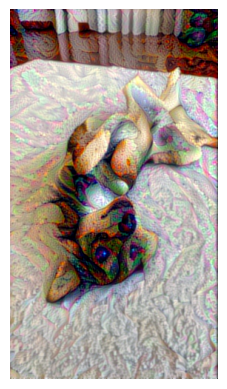

Average Total Loss: 491.66983250935874
Average Content Loss: 0.6231860648274353
Average Style Loss: 307.43057645161946
Average Variation Loss: 183.61606941223144


In [25]:
style_layer_names2 = ['block1_conv1',
                     'block2_conv1',
                     'block3_conv1',
                     'block4_conv1',
                      ]

content_layer_name2 = [
    'block2_conv2',
    'block3_conv3',
    'block4_conv3',
    'block5_conv2',   ]

total_variation_weight = 1e-7
style_weight = 1e-7
content_weight = 2.5e-9

num_content_layers = len(content_layer_name2)
num_style_layers = len(style_layer_names2)


model5 = vgg19.VGG19(weights="imagenet", include_top=False)


outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])


feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

base_image = preprocess_image(content_path)
style_reference_image = preprocess_image(style_path)

content_features = feature_extractor(base_image)

content_targets = {
    layer_name: content_features[layer_name]
    for layer_name, value
    in content_features.items()
    if layer_name in content_layer_name
}

style_features = feature_extractor(style_reference_image)

style_targets = {
    layer_name: gram_matrix(style_features[layer_name][0])
    for layer_name, value
    in style_features.items()
    if layer_name in style_layer_names
}

def style_loss(style, target):
    T = gram_matrix(target)
    channels = 3
    size = img_height * img_width

    return tf.reduce_sum(tf.square(style - T)) / (4.0 * (channels ** 2) * (size ** 2))

def content_loss(content, target):
    return tf.reduce_sum(tf.square(target - content))


def total_variation_loss(x):

    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :]

        - x[:, 1:, : img_width - 1, :]
    )

    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :]

         - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss, c_loss, s_loss, v_loss = compute_loss(combination_image)
    grads = tape.gradient(loss, combination_image)
    optimizer.apply_gradients([(grads, combination_image)])
    return loss, c_loss, s_loss, v_loss

    learning_rate = 100.


optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=learning_rate,
    beta_1=0.99,
    epsilon=1e-1)

combination_image = tf.Variable(preprocess_image(content_path))

iterations = 600
display_every = 600
print_every = 20
save_intermediate = False

tot_loss = 0
tot_content_loss = 0
tot_style_loss = 0
tot_variation_loss = 0

for i in range(1, iterations + 1):
    start = time.time()
    loss, c_loss, s_loss, var_loss = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    end = time.time()

    tot_loss += loss.numpy().item()
    tot_content_loss += c_loss.numpy().item()
    tot_style_loss += s_loss.numpy().item()
    tot_variation_loss += var_loss.numpy().item()

    if i % print_every == 0:
        l = loss.numpy().item()
        c_l = c_loss.numpy().item()
        s_l = s_loss.numpy().item()
        v_l = var_loss.numpy().item()
        print(f"{i} | loss: {l:,.0f} content: {c_l:,.0f} style: {s_l:,.0f} variation: {v_l:,.0f} | time: {end-start:.4f}")

    if i % display_every == 0:
        img = deprocess_image(combination_image.numpy())
        if save_intermediate:
            fname = basedir / f"Model5_image_at_iteration_{i}.png"
            tf.keras.utils.save_img(fname, img)
        plt.axis('off')
        plt.imshow(img)
        plt.show()
avg_total_loss5 = tot_loss / iterations
avg_content_loss5 = tot_content_loss / iterations
avg_style_loss5 = tot_style_loss / iterations
avg_variation_loss5 = tot_variation_loss / iterations


print(f"Average Total Loss: {avg_total_loss5}")
print(f"Average Content Loss: {avg_content_loss5}")
print(f"Average Style Loss: {avg_style_loss5}")
print(f"Average Variation Loss: {avg_variation_loss5}")

img = deprocess_image(combination_image.numpy())
fname = basedir / f"Model5_image_at_iteration_{iterations}.png"
tf.keras.utils.save_img(fname, img)




In [26]:
loss_data = {
    'Model' : ['Base', 'Model1', 'Model2', 'Model3', 'Model4', 'Model5'],
    'Avr. Total Loss' : [avg_total_loss_base, avg_total_loss1, avg_total_loss2, avg_total_loss3, avg_total_loss4, avg_total_loss5],
    'Avr. Content Loss' : [avg_content_loss_base, avg_content_loss1, avg_content_loss2, avg_content_loss3, avg_content_loss4, avg_content_loss5],
    'Avr. Style Loss' : [avg_style_loss_base, avg_style_loss1, avg_style_loss2, avg_style_loss3, avg_style_loss4, avg_style_loss5],
    'Avr. Variation Loss' : [avg_variation_loss_base, avg_variation_loss1, avg_variation_loss2, avg_variation_loss3, avg_variation_loss4, avg_variation_loss5]
}

loss_df= pd.DataFrame(loss_data)
loss_df

,Model,Avr. Total Loss,Avr. Content Loss,Avr. Style Loss,Avr. Variation Loss
0,Base,4724.735123,28.597640,2594.520888,2101.616585
1,Model1,2892.532365,26.837345,1428.059550,1437.635464
2,Model2,2873.215883,6.990846,1427.610708,1438.614324
3,Model3,11569.725195,76.349448,7277.508903,4215.866819
4,Model4,17958.857211,78.447814,6526.140481,11354.268925
5,Model5,491.669833,0.623186,307.430576,183.616069


A significant decrease was observed in all losses. However, I see that the combination in the image has decreased significantly.

#### 3.3.6 Model6- Adding a Layer to Style and Removing 2 Layers From Content and Increasing Style Weight

Now, to increase the synthesis in the combination, I will remove 2 of the content layers and raise the style weights. Although these steps will increase the number of losses, I expect to obtain a more homogeneous visual.

20 | loss: 5,148 content: 1 style: 4,767 variation: 380 | time: 0.0411
40 | loss: 3,893 content: 1 style: 3,480 variation: 412 | time: 0.0498
60 | loss: 2,669 content: 1 style: 2,239 variation: 429 | time: 0.0432
80 | loss: 2,165 content: 1 style: 1,713 variation: 450 | time: 0.1513
100 | loss: 1,900 content: 1 style: 1,431 variation: 468 | time: 0.1966
120 | loss: 1,682 content: 1 style: 1,200 variation: 480 | time: 0.1436
140 | loss: 1,499 content: 1 style: 1,016 variation: 482 | time: 0.0502
160 | loss: 1,349 content: 1 style: 872 variation: 475 | time: 0.0421
180 | loss: 1,224 content: 1 style: 757 variation: 465 | time: 0.1085
200 | loss: 1,120 content: 1 style: 669 variation: 450 | time: 0.0942
220 | loss: 1,031 content: 1 style: 598 variation: 432 | time: 0.0600
240 | loss: 951 content: 1 style: 538 variation: 411 | time: 0.0462
260 | loss: 879 content: 1 style: 488 variation: 390 | time: 0.0432
280 | loss: 817 content: 1 style: 447 variation: 368 | time: 0.0437
300 | loss: 762 

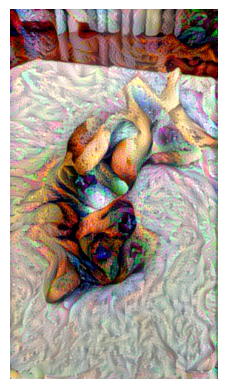

Average Total Loss: 1424.0980420939127
Average Content Loss: 1.4374548032072683
Average Style Loss: 1091.8872136688233
Average Variation Loss: 330.7733775838216


In [27]:
style_layer_names2 = ['block1_conv1',
                     'block2_conv1',
                     'block3_conv1',
                     'block4_conv1',
                     'block5_conv1',
                      ]

content_layer_name2 = ['block4_conv3',
                       'block5_conv2',]

total_variation_weight = 1e-7
style_weight = 1e-6
content_weight = 2.5e-9

num_content_layers = len(content_layer_name2)
num_style_layers = len(style_layer_names2)


model6 = vgg19.VGG19(weights="imagenet", include_top=False)


outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])


feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

base_image = preprocess_image(content_path)
style_reference_image = preprocess_image(style_path)

content_features = feature_extractor(base_image)

content_targets = {
    layer_name: content_features[layer_name]
    for layer_name, value
    in content_features.items()
    if layer_name in content_layer_name
}

style_features = feature_extractor(style_reference_image)

style_targets = {
    layer_name: gram_matrix(style_features[layer_name][0])
    for layer_name, value
    in style_features.items()
    if layer_name in style_layer_names
}

def style_loss(style, target):
    T = gram_matrix(target)
    channels = 3
    size = img_height * img_width

    return tf.reduce_sum(tf.square(style - T)) / (4.0 * (channels ** 2) * (size ** 2))

def content_loss(content, target):
    return tf.reduce_sum(tf.square(target - content))


def total_variation_loss(x):

    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :]

        - x[:, 1:, : img_width - 1, :]
    )

    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :]

         - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss, c_loss, s_loss, v_loss = compute_loss(combination_image)
    grads = tape.gradient(loss, combination_image)
    optimizer.apply_gradients([(grads, combination_image)])
    return loss, c_loss, s_loss, v_loss

    learning_rate = 100.


optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=learning_rate,
    beta_1=0.99,
    epsilon=1e-1)

combination_image = tf.Variable(preprocess_image(content_path))

iterations = 600
display_every = 600
print_every = 20
save_intermediate = False

tot_loss = 0
tot_content_loss = 0
tot_style_loss = 0
tot_variation_loss = 0

for i in range(1, iterations + 1):
    start = time.time()
    loss, c_loss, s_loss, var_loss = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    end = time.time()

    tot_loss += loss.numpy().item()
    tot_content_loss += c_loss.numpy().item()
    tot_style_loss += s_loss.numpy().item()
    tot_variation_loss += var_loss.numpy().item()

    if i % print_every == 0:
        l = loss.numpy().item()
        c_l = c_loss.numpy().item()
        s_l = s_loss.numpy().item()
        v_l = var_loss.numpy().item()
        print(f"{i} | loss: {l:,.0f} content: {c_l:,.0f} style: {s_l:,.0f} variation: {v_l:,.0f} | time: {end-start:.4f}")

    if i % display_every == 0:
        img = deprocess_image(combination_image.numpy())
        if save_intermediate:
            fname = basedir / f"Model6_image_at_iteration_{i}.png"
            tf.keras.utils.save_img(fname, img)
        plt.axis('off')
        plt.imshow(img)
        plt.show()
avg_total_loss6 = tot_loss / iterations
avg_content_loss6 = tot_content_loss / iterations
avg_style_loss6 = tot_style_loss / iterations
avg_variation_loss6 = tot_variation_loss / iterations


print(f"Average Total Loss: {avg_total_loss6}")
print(f"Average Content Loss: {avg_content_loss6}")
print(f"Average Style Loss: {avg_style_loss6}")
print(f"Average Variation Loss: {avg_variation_loss6}")

img = deprocess_image(combination_image.numpy())
fname = basedir / f"Model6_image_at_iteration_{iterations}.png"
tf.keras.utils.save_img(fname, img)




In [28]:
loss_data = {
    'Model' : ['Base', 'Model1', 'Model2', 'Model3', 'Model4', 'Model5', 'Model6'],
    'Avr. Total Loss' : [avg_total_loss_base, avg_total_loss1, avg_total_loss2, avg_total_loss3, avg_total_loss4, avg_total_loss5, avg_total_loss6],
    'Avr. Content Loss' : [avg_content_loss_base, avg_content_loss1, avg_content_loss2, avg_content_loss3, avg_content_loss4, avg_content_loss5, avg_content_loss6],
    'Avr. Style Loss' : [avg_style_loss_base, avg_style_loss1, avg_style_loss2, avg_style_loss3, avg_style_loss4, avg_style_loss5, avg_style_loss6],
    'Avr. Variation Loss' : [avg_variation_loss_base, avg_variation_loss1, avg_variation_loss2, avg_variation_loss3, avg_variation_loss4, avg_variation_loss5, avg_variation_loss6 ]
}

loss_df= pd.DataFrame(loss_data)
loss_df

,Model,Avr. Total Loss,Avr. Content Loss,Avr. Style Loss,Avr. Variation Loss
0,Base,4724.735123,28.597640,2594.520888,2101.616585
1,Model1,2892.532365,26.837345,1428.059550,1437.635464
2,Model2,2873.215883,6.990846,1427.610708,1438.614324
3,Model3,11569.725195,76.349448,7277.508903,4215.866819
4,Model4,17958.857211,78.447814,6526.140481,11354.268925
5,Model5,491.669833,0.623186,307.430576,183.616069
6,Model6,1424.098042,1.437455,1091.887214,330.773378


## 4. Evaluating and Conclusion

If I evaluate the six models, it seems that the most suitable model in terms of numerical data is Model5, but due to the small number of combinations in the image, I think Model6 is the most appropriate model.

From the project's first step until now, I had to use Adam Optimization with the .legacy function. (Due to Apple M2 chip).

The models in the project can be improved with different optimization functions, weight and iteration adjustments, and a more robust model can be created.

## 5. References


1. Content image: Unal, Alperen. My Lovely Dog Foxy. 6 Oct. 2022.
2. Style image: Refik Anadol, Yawanawa -https://x.com/misterduchamp/status/1743028832666267750?s=20
3. CHOLLET, Francois (2021) Deep learning with python, 2nd Edition, Manning
4. WENGER, Jeremie (2023), Artificial Intelligence Notebooks, Goldsmiths, University of London